# Clone my driving behavior

In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Lambda, Cropping2D, Activation, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
from livelossplot import PlotLossesKeras

import cloning.image_generator as ig
from cloning.visualizations import plot_layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
user = !whoami
user = user[0]

In [4]:
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'
IMAGE_SHAPE = (160, 320, 3)

IMAGE_DIRECTORIES = [
    'first_drives', 
    '3_forward_rounds', 
    '3_backward_rounds',
    'edges_forward',
    'edges_backward',
    'edges_smooth',
    '2_rounds_for_testing',
    '3_more_fw_rounds',
    '3_more_bw_rounds',
    ('driving_on_the_edge_fw_left', 0.15),
    ('driving_on_the_edge_fw_right', -0.15),
#     '6_fw',
#     '6_bw',
#     '3_bw_hard',
#     '3_fw_hard',
#     '1_round_fw_hard_level'
]

LOAD_ALL_IMAGES_IN_MEMORY = False
BATCH_SIZE = 32
TRAIN_SET_SIZE = ig.load_image_registries(PROJECT_DIR, IMAGE_DIRECTORIES).shape[0]

## Load images and measurements

In [5]:
if LOAD_ALL_IMAGES_IN_MEMORY:
    all_data = ig.load_all_images(PROJECT_DIR, IMAGE_DIRECTORIES)
    train_generator = ig.image_generator_from_dataset(*all_data, batch_size=BATCH_SIZE, augment=True)
else:
    train_generator = ig.image_generator_from_files(PROJECT_DIR, IMAGE_DIRECTORIES, batch_size=BATCH_SIZE, augment=True)
    
print(f'Number of train samples: {TRAIN_SET_SIZE}')

Number of train samples: 26452


In [6]:
%%time
valid_images, valid_meas = ig.load_all_images(PROJECT_DIR, ['validation_rounds', 'validation_rounds_bw'])
print(f'Number of valid samples: {valid_meas.shape[0]}')

Number of valid samples: 4234
CPU times: user 4.87 s, sys: 520 ms, total: 5.39 s
Wall time: 5.39 s


In [7]:
%%time
test_images, test_meas = ig.load_all_images(PROJECT_DIR, ['test_rounds', 'test_rounds_bw'])
print(f'Number of test samples: {test_meas.shape[0]}')

Number of test samples: 5463
CPU times: user 6.08 s, sys: 796 ms, total: 6.87 s
Wall time: 6.87 s


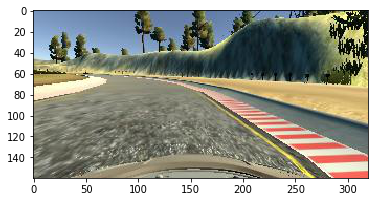

In [8]:
plt.imshow(next(train_generator)[0][0])
plt.show()

In [9]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE, name='crop'),
    Lambda(lambda image: image / 255.0 - 0.5, name='scale'),
    
    Conv2D(24, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
crop (Cropping2D)            (None, 65, 320, 3)        0         
_________________________________________________________________
scale (Lambda)               (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 158, 24)       96        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 77, 36)        144       
__________

## Train model

In [11]:
%%time
steps_per_epoch = int(TRAIN_SET_SIZE / BATCH_SIZE)
validation_steps = int(valid_meas.shape[0] / BATCH_SIZE)

model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


826/826 [==============================] - 26s 32ms/step - loss: 0.0166 - val_loss: 0.0078
CPU times: user 37.4 s, sys: 5.35 s, total: 42.7 s
Wall time: 27.7 s


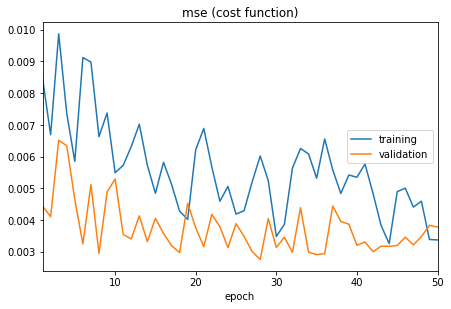

mse (cost function):
training   (min:    0.003, max:    0.010, cur:    0.003)
validation (min:    0.003, max:    0.007, cur:    0.004)
CPU times: user 31min 41s, sys: 3min 5s, total: 34min 47s
Wall time: 20min 52s


In [12]:
%%time
model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[PlotLossesKeras()],
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

In [17]:
test_mse = model.evaluate(test_images, test_meas)
test_rmse = np.sqrt(test_mse)
print(f'Test set MSE: {test_mse:.3f}')
print(f'Test set RMSE: {test_rmse:.3f}')

5463/5463 [==============================] - 2s 420us/step
Test set MSE: 0.004
Test set RMSE: 0.062


In [14]:
model.save('./models/model_nvidia_avoiding_edges_with_fixed_angle.h5')

In [15]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_avoiding_edges_with_fixed_angle.h5 to s3://behavioral-cloning-models/model_nvidia_avoiding_edges_with_fixed_angle.h5


## Compare original and predicted angle distributions

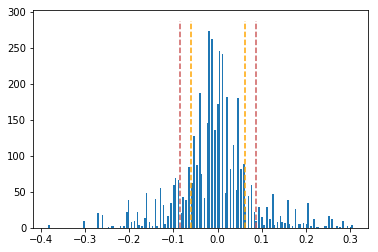

In [24]:
plt.hist(valid_meas, bins=200)
ylim = plt.ylim()
test_std = test_meas.std()
test_mean = test_meas.mean()

plt.vlines(test_rmse + test_mean, *ylim, color='orange', linestyle='--')
plt.vlines(-test_rmse + test_mean, *ylim, color='orange', linestyle='--')
plt.vlines(test_std + test_mean, *ylim, color='indianred', linestyle='--')
plt.vlines(-test_std + test_mean, *ylim, color='indianred', linestyle='--')
plt.show()

In [20]:
%%time
predictions = model.predict(valid_images)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 1.93 s


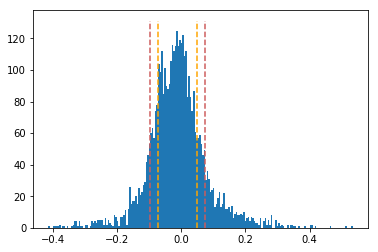

In [25]:
plt.hist(predictions, bins=200)
ylim = plt.ylim()
predictions_mean = predictions.mean()

plt.vlines(test_rmse + predictions_mean, *ylim, color='orange', linestyle='--')
plt.vlines(-test_rmse + predictions_mean, *ylim, color='orange', linestyle='--')
plt.vlines(test_std + predictions_mean, *ylim, color='indianred', linestyle='--')
plt.vlines(-test_std + predictions_mean, *ylim, color='indianred', linestyle='--')

plt.show()

## Visualize output of convolution layers

In [29]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

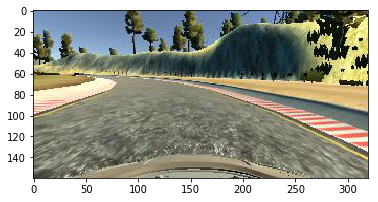

In [30]:
test_image = test_images[0]
plt.imshow(test_image)
plt.show()

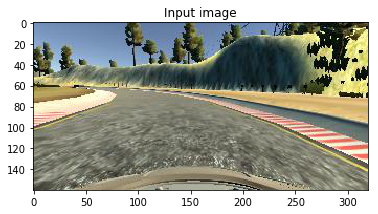

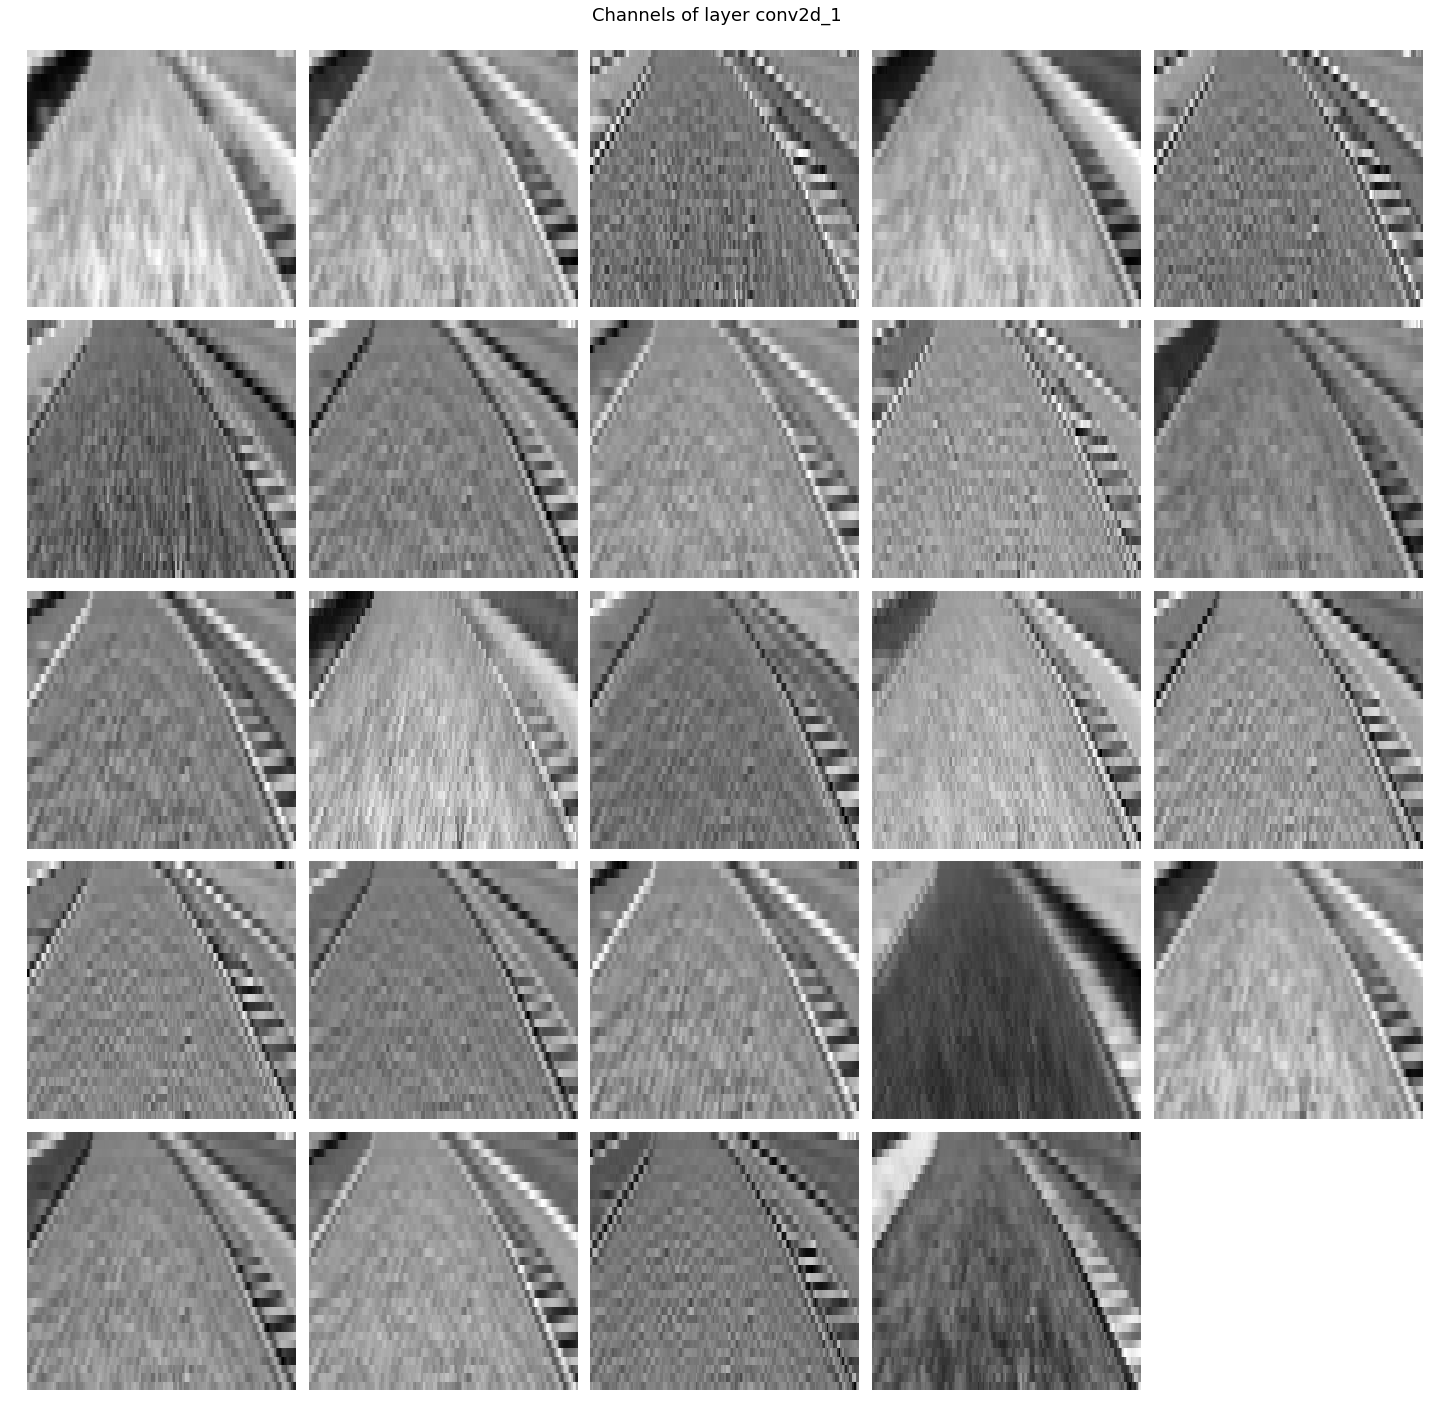

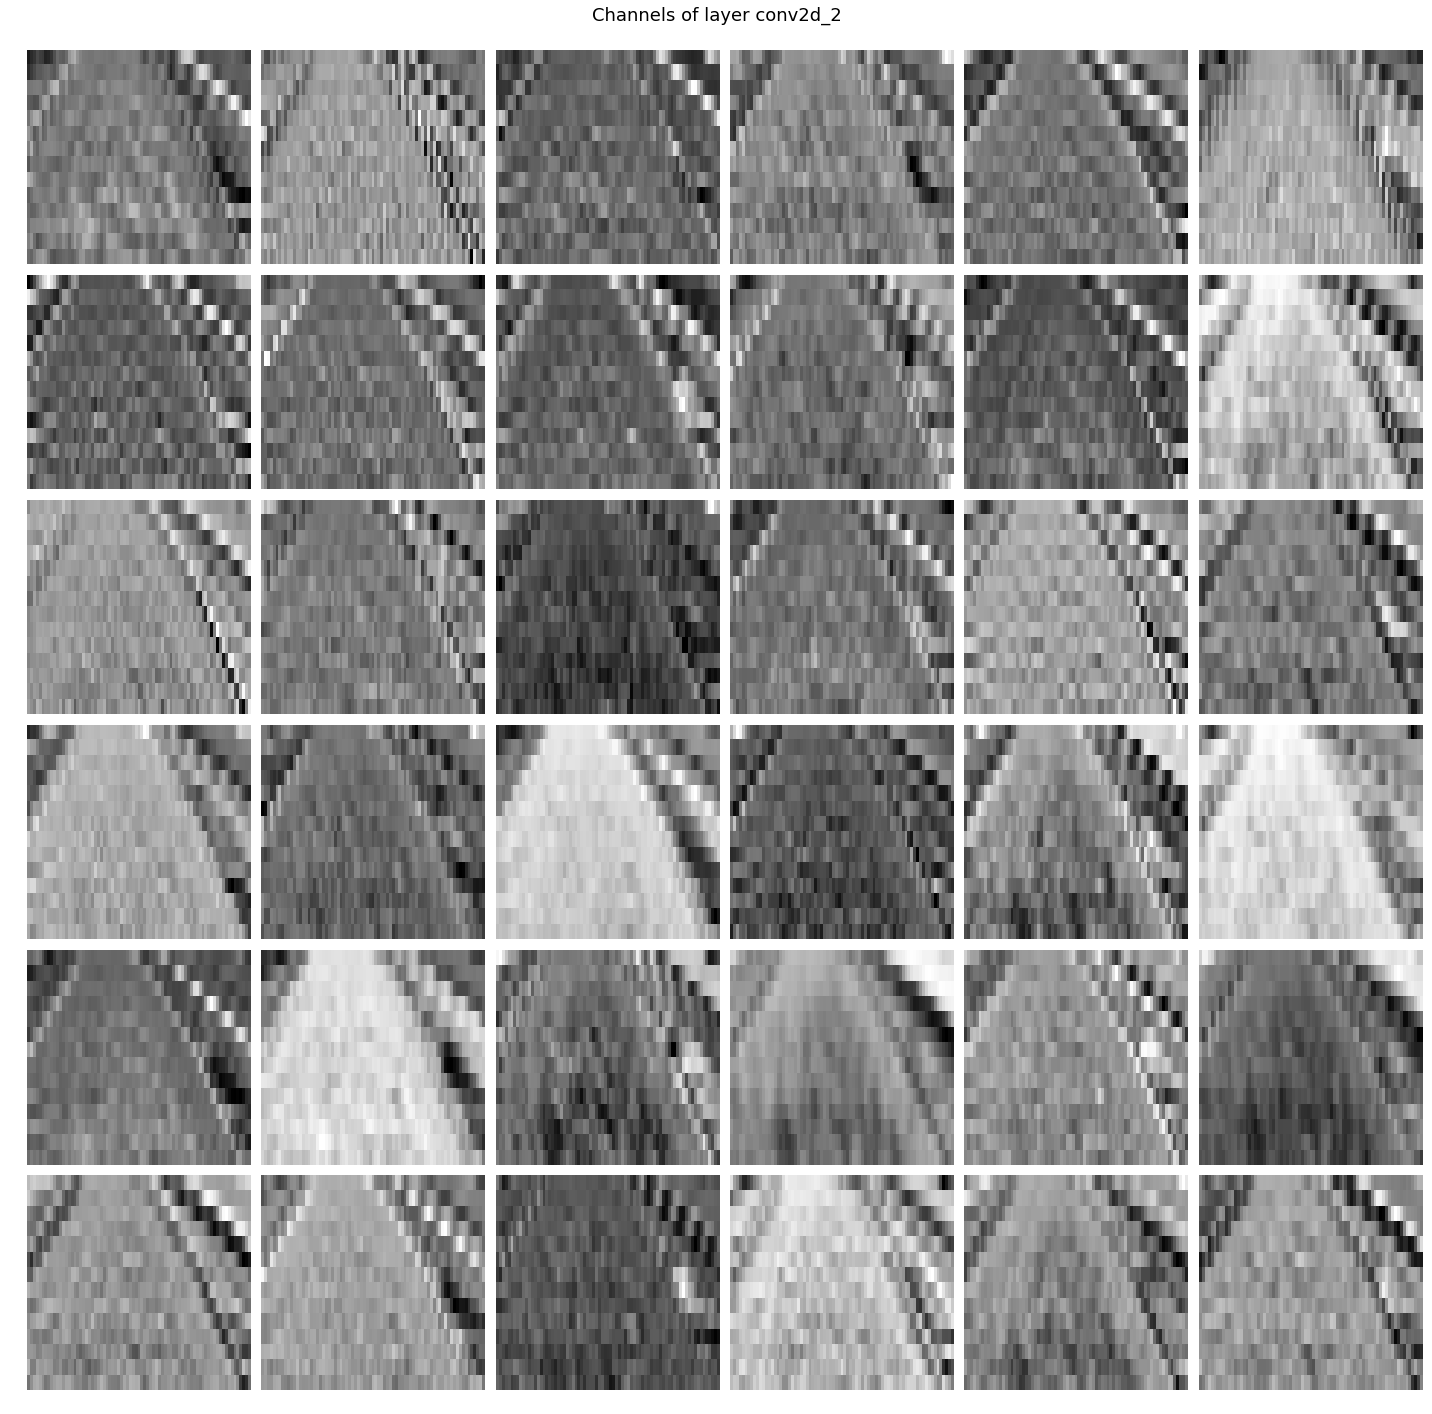

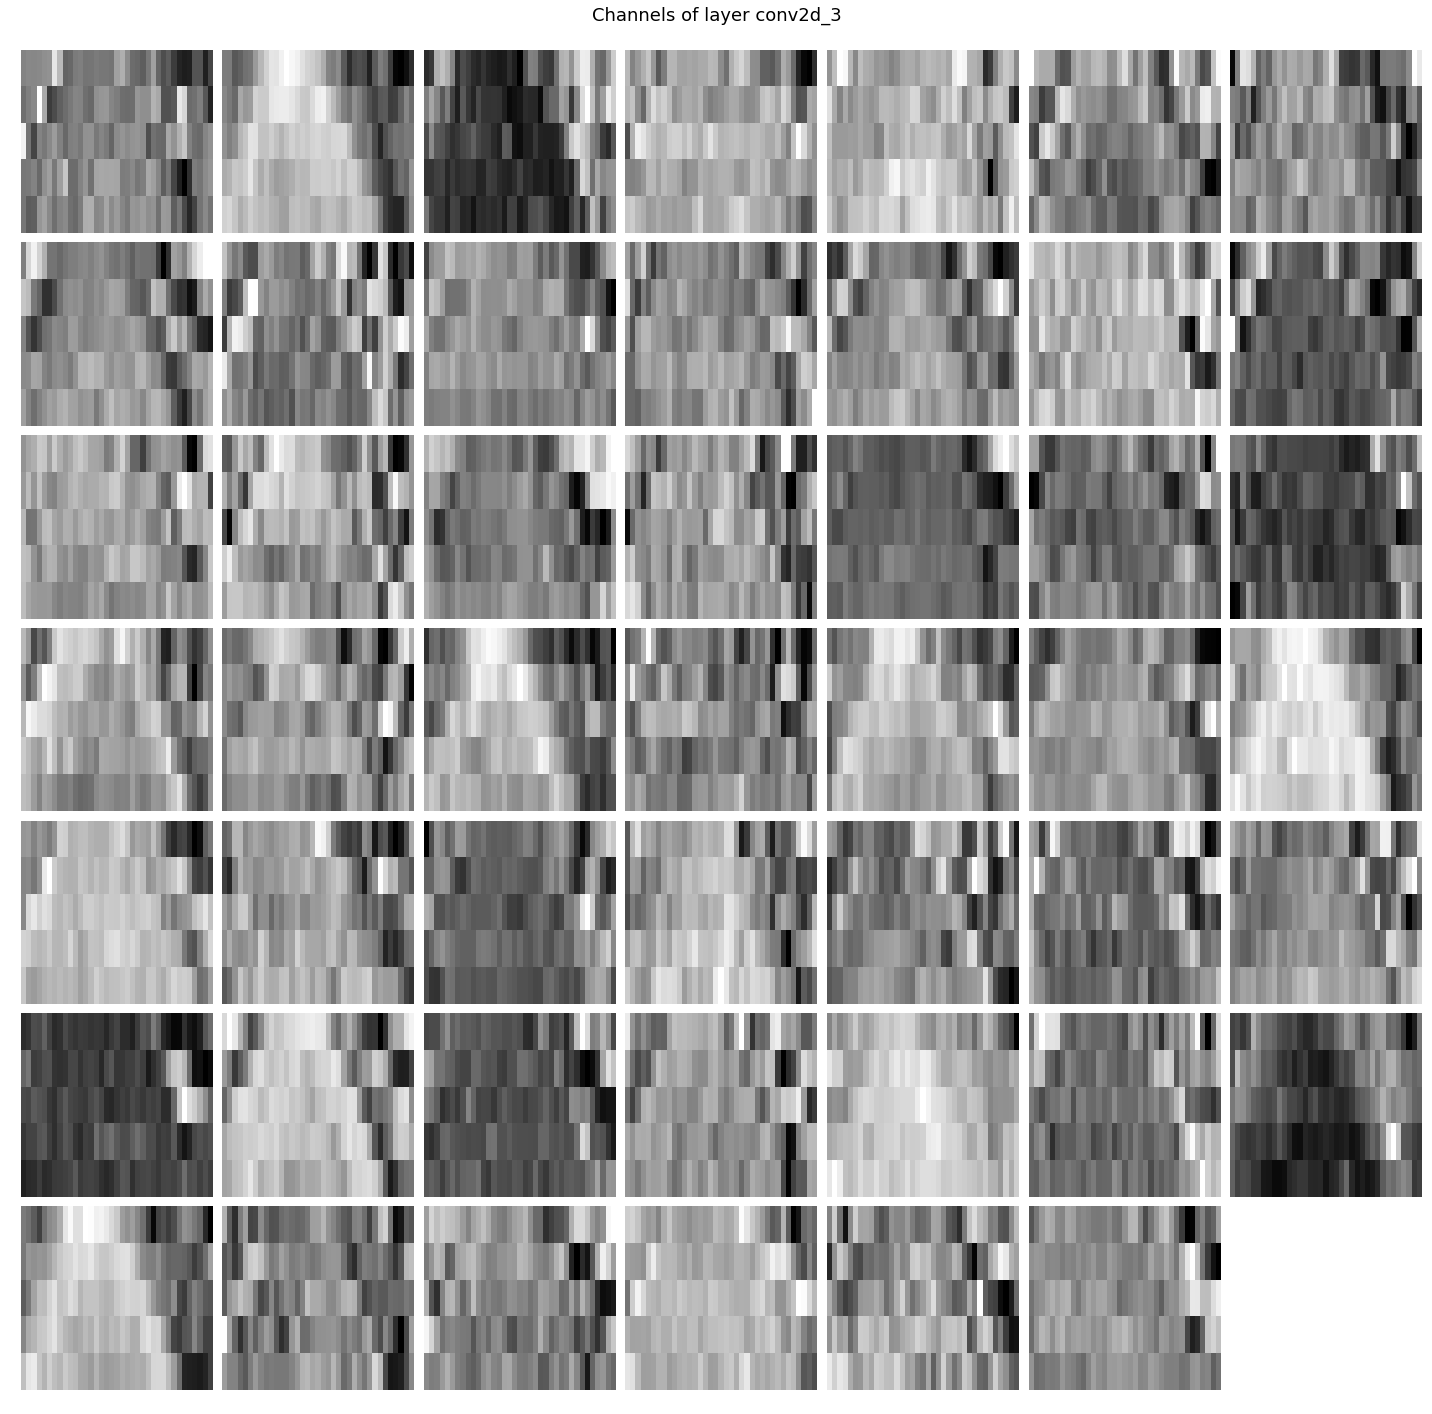

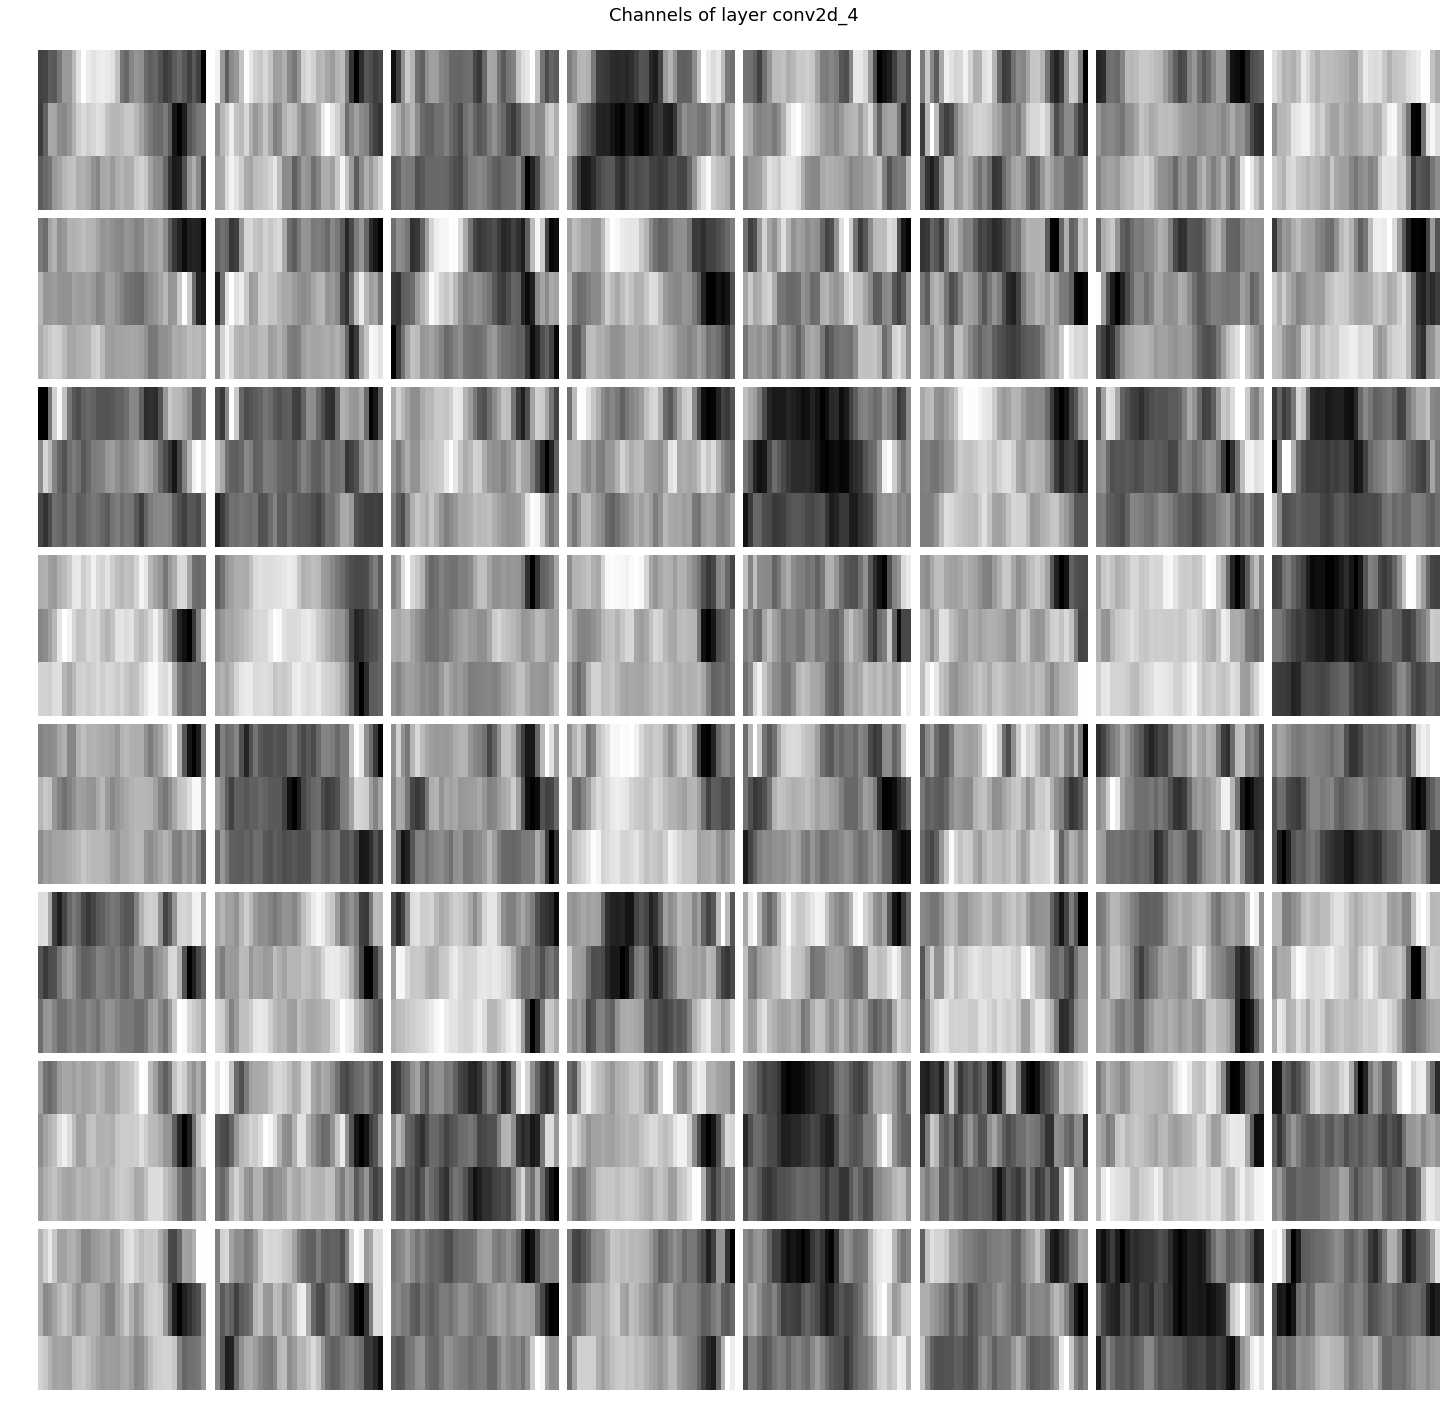

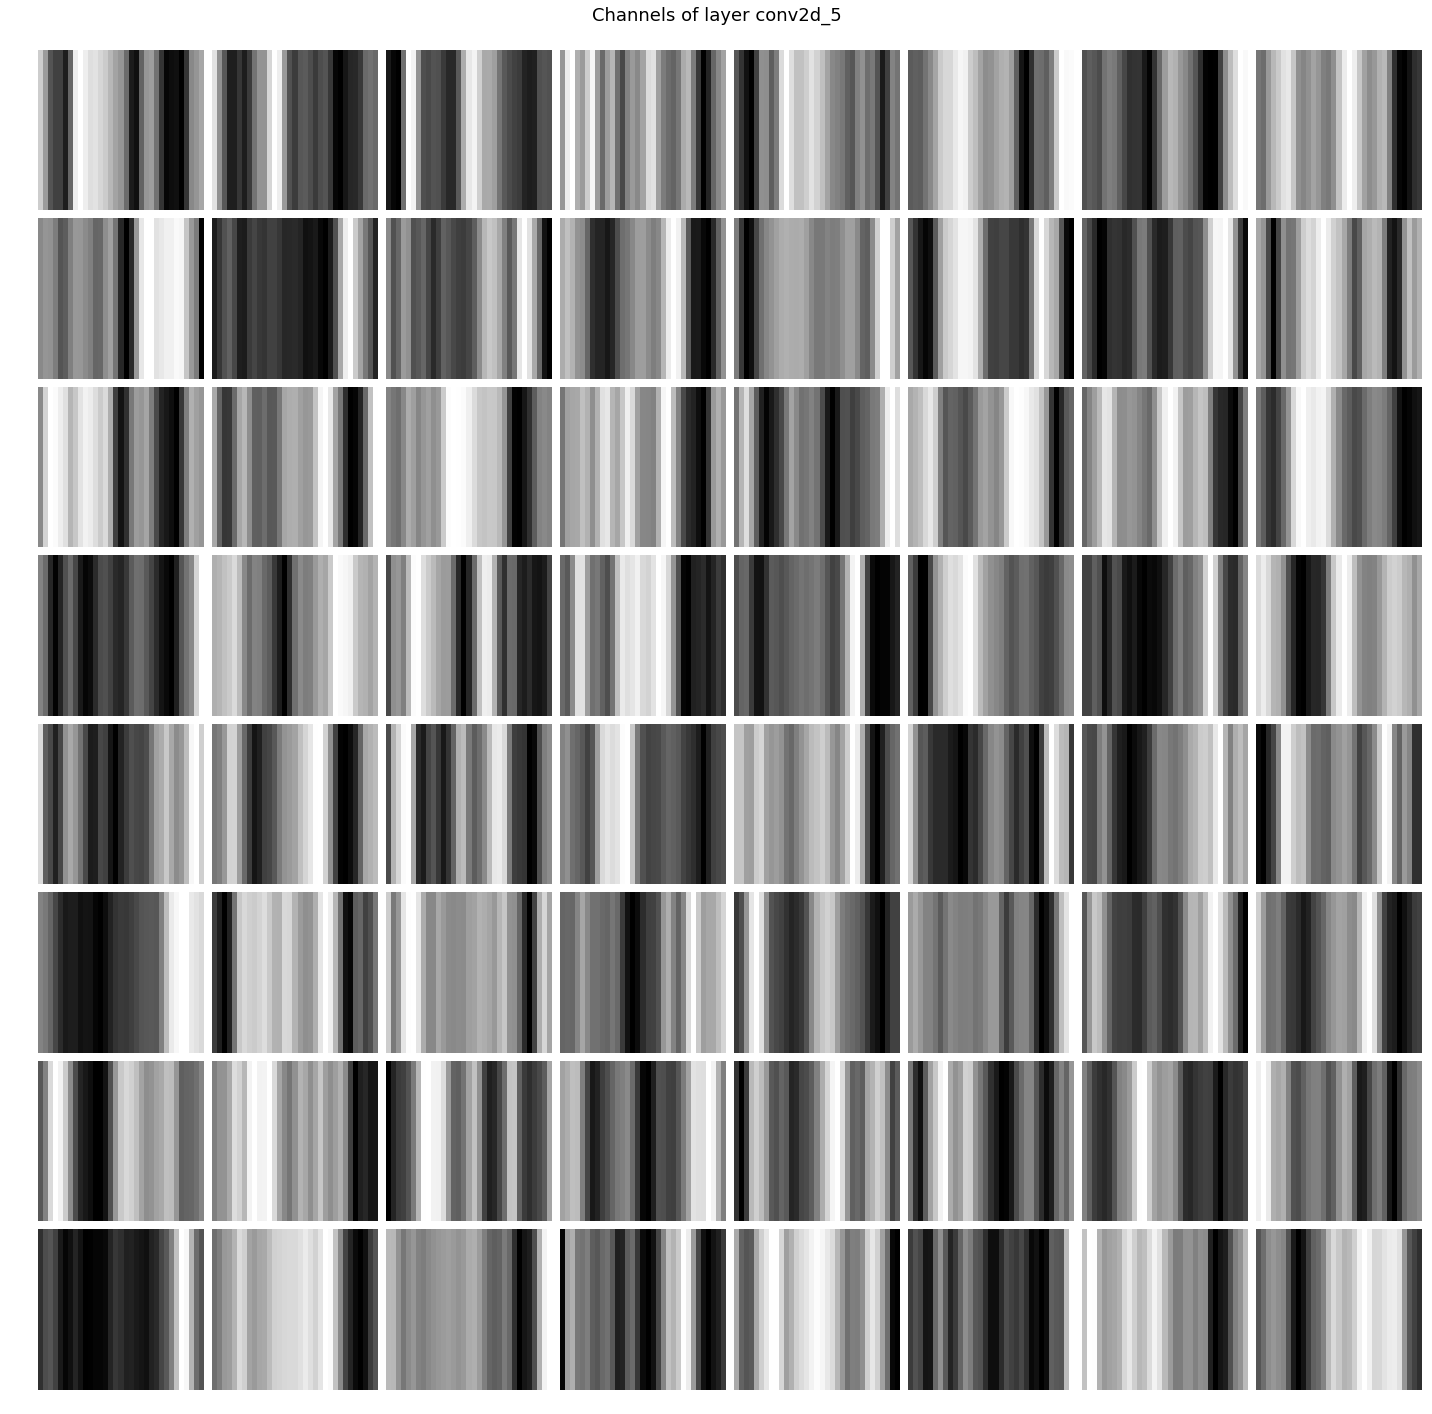

In [31]:
plot_layers(test_image, evaluation_functions, layer_names)